# Inteligência Artificial Preditiva: Auto ML

## Este notebook tem como objetivo explorar 5 principais modelos de inteligência artificial preditiva:
### Regressão 
    1. Regressão Linear
    2. K-Nearest Neighbors Regressor
### Classificação
    3. Naive Bayes
    4. Decision Tree: Gini
    5. Decision Tree: Entropia
    6. K-Nearest Neighbors (KNN)
    7. XGBoost

## Desses 7, usaremos a que melhor performou para a base de dados que você irá inserir!

#### CODEOWNERS:
- **Rafael Cruz** [GitHub](https://github.com/RafaelBarretoCruz)
- **Gabriel Martins** [GitHub](https://github.com/GabrielOliveiraGerminare1H)
- **Fellipe Meira** [GitHub](https://github.com/fellipemeiraGerminare)



<h1> Importando bibliotecas </h1>

In [16]:
# Importações das bibliotecas gerais
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Importações dos modelos e separação de treino/teste

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Importações das métricas e pré-processamento
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error,
        accuracy_score,
        confusion_matrix,
        f1_score,
        ConfusionMatrixDisplay, \
        precision_score,
        recall_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Importações para visualizações
import yellowbrick.classifier as yb


# Setando opções do pandas para não diminuir o número de colunas exibidas
pd.set_option('display.max_columns', None)


<h1> Carregando a base de dados </h1>

In [17]:
# Solicita o nome do arquivo CSV ao usuário
# csv_nome = input("Digite o nome do arquivo CSV (incluindo a extensão .csv): ")

csv_nome="Student_Performance.csv" # Exemplo fixo para testes

caminho = os.path.join(os.getcwd(), "datasets", csv_nome)

# Detecta o delimitador automaticamente
with open(caminho, "r", encoding="utf-8") as f:
    sniffer = csv.Sniffer()
    sample = f.read(2048)
    f.seek(0)
    delimiter_encontrado = sniffer.sniff(sample).delimiter

print(f"Delimitador detectado: '{delimiter_encontrado}'")

# Carrega o arquivo CSV usando o delimitador detectado
try:
    data = pd.read_csv(caminho, delimiter=delimiter_encontrado)
    print("Arquivo carregado!")
except FileNotFoundError:
    print("Arquivo não encontrado. Verifique o nome e o caminho do arquivo.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")

Delimitador detectado: ','
Arquivo carregado!


<h1> Primeira visualização da base</h1>

In [18]:
display(data.head())

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


<h1> Definindo a coluna que será prevista (variável target)</h1>

In [19]:
# Pedindo ao usuário para definir a coluna target
# coluna_target = input("Digite o nome da coluna que você deseja prever (variável target): ")

coluna_target='Performance Index'  # Exemplo fixo para testes

# Verificando se a coluna existe na base de dados
if coluna_target not in data.columns:
    raise ValueError(f"A coluna '{coluna_target}' não existe na base de dados.")
else:
    x = data.drop(columns=[coluna_target])
    y = data[coluna_target]

<h1> Pré-processamento dos dados </h1>

In [20]:
classes_por_extenso = y.unique()


# Identificar colunas numéricas e categóricas
num_cols = x.select_dtypes(include=["int64", "float64"]).columns
cat_cols = x.select_dtypes(include=["object", "category"]).columns

# Codificar colunas categóricas (LabelEncoder não precisa de Grid Search)
for col in cat_cols:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col].astype(str))

# Definir pipelines para pré-processamento (imputação e escalonamento)
# Para imputação, vamos considerar 'mean', 'median' e 'most_frequent'
# Para escalonamento, vamos considerar StandardScaler e MinMaxScaler

# Apenas se houver colunas numéricas
if len(num_cols) > 0:
    pipeline_preprocessing = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())
    ])

    param_grid_preprocessing = {
        'imputer__strategy': ['mean', 'median', 'most_frequent'],
        'scaler': [StandardScaler(), MinMaxScaler()]
    }

    grid_search_preprocessing = GridSearchCV(pipeline_preprocessing, param_grid_preprocessing, cv=5, scoring='r2' if y.dtype != 'object' else 'accuracy')
    grid_search_preprocessing.fit(x[num_cols], y)

    print("Melhores parâmetros para pré-processamento:", grid_search_preprocessing.best_params_)
    print("Melhor score para pré-processamento:", grid_search_preprocessing.best_score_)

    # Aplicar o melhor pré-processamento aos dados numéricos
    best_imputer = grid_search_preprocessing.best_estimator_.named_steps['imputer']
    best_scaler = grid_search_preprocessing.best_estimator_.named_steps['scaler']

    x[num_cols] = best_imputer.fit_transform(x[num_cols])
    x[num_cols] = best_scaler.fit_transform(x[num_cols])
else:
    print("Não há colunas numéricas para pré-processamento de imputação e escalonamento.")

if y.dtype == 'object':
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)

C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^

Melhores parâmetros para pré-processamento: {'imputer__strategy': 'mean', 'scaler': StandardScaler()}
Melhor score para pré-processamento: nan


C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^

<h1> Visualizando novamente a base de dados </h1>

In [21]:
display(x.head())

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
0,0.775188,1.704176,1,1.456205,-1.249754
1,-0.383481,0.723913,0,-1.492294,-0.900982
2,1.161410,-1.063626,1,0.276805,-0.900982
3,0.002742,-1.005963,1,-0.902594,-0.900982
4,0.775188,0.320275,0,0.866505,0.145333


<h1> Separação entre treino e teste </h1>

In [22]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y,
                                                        test_size=0.2,
                                                        random_state=42)


<h1> Detectando o tipo da variável target para seguirmos com o modelo</h1>

In [23]:
resultados = {}

# Determinar se é um problema de classificação ou regressão
if len(np.unique(y)) < 20 or y.dtype == 'object':
    problema = "classificacao"
    modelos = {
        "Decision Tree: Gini": DecisionTreeClassifier(criterion='gini', random_state=42),
        "Decision Tree: Entropia": DecisionTreeClassifier(criterion='entropy', random_state=42),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(),
        "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
    }
    param_grids = {
        "Decision Tree: Gini": {
            'max_depth': [None, 10, 20, 30],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2, 5, 10],
            'splitter': ['best', 'random'],
            'ccp_alpha': [0.0, 0.01, 0.1],
            'class_weight': [None, 'balanced']
        },
        "Decision Tree: Entropia": {
            'max_depth': [None, 10, 20, 30],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2, 5, 10],
            'splitter': ['best', 'random'],
            'ccp_alpha': [0.0, 0.01, 0.1],
            'class_weight': [None, 'balanced']
        },
        "Naive Bayes": {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        },
        "KNN": {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine'],
        },
        "XGBoost": {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.01, 0.1],
            "subsample": [0.8],
            "colsample_bytree": [0.8,  1.0],
            "random_state": [42],
            "tree_method": ["exact", "approx", "gpu_hist"]
        }
    }
    scoring_metric = 'accuracy'
# Se for regressão, apenas Regressão Linear
else:
    problema = "regressao"
    modelos = {
        "Regressão Linear": LinearRegression(),
        "KNN Regressor": KNeighborsRegressor()
    }
    param_grids = {
        "Regressão Linear": {
            "fit_intercept": [True, False],
            "positive": [True, False]
        },
        "KNN Regressor": {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [20, 30, 40],
        }
    }
    scoring_metric = 'r2'

<h1> Treinando e avaliando os modelos </h1>

In [24]:
best_models = {}

for nome, modelo in modelos.items():
    grid_search = GridSearchCV(modelo, param_grids[nome], cv=5, scoring=scoring_metric)
    grid_search.fit(x_treino, y_treino)

    best_models[nome] = grid_search.best_estimator_
    y_pred = best_models[nome].predict(x_teste)

    if problema == "classificacao":
        acc = accuracy_score(y_teste, y_pred)
        f1 = f1_score(y_teste, y_pred, average="weighted")
        precision = precision_score(y_teste, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_teste,y_pred, average="weighted", zero_division=0)
        resultados[nome] = {"Acurácia": acc, "F1-Score": f1, "Precisão": precision, "Recall": recall, "Melhores Parâmetros": grid_search.best_params_}
    else:
        mse = mean_squared_error(y_teste, y_pred)
        r2 = r2_score(y_teste, y_pred)
        mae = median_absolute_error(y_teste, y_pred)
        mape = mean_absolute_percentage_error(y_teste, y_pred)

        resultados[nome] = {"MSE": mse, "R²": r2, "MAE": mae, "MAPE": mape, "Melhores Parâmetros": grid_search.best_params_}

C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rafaelcruz-ieg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5

<h1> Resultados dos modelos </h1>

In [25]:
display(pd.DataFrame(resultados))

# Transpondo para melhor visualização
df_resultados = pd.DataFrame(resultados).T
display(df_resultados)

# Identificar melhor modelo de classificação
if problema == "classificacao":
    melhor = df_resultados["Acurácia"].idxmax()

# Aplicando para regressão
else:
    melhor = df_resultados["R²"].idxmax()


,Regressão Linear,KNN Regressor
MSE,4.082628,7.369031
R²,0.988983,0.980115
MAE,1.358721,1.899167
MAPE,0.034999,0.04841
Melhores Parâmetros,"{'fit_intercept': True, 'positive': True}","{'algorithm': 'ball_tree', 'leaf_size': 20, 'm..."


,MSE,R²,MAE,MAPE,Melhores Parâmetros
Regressão Linear,4.082628,0.988983,1.358721,0.034999,"{'fit_intercept': True, 'positive': True}"
KNN Regressor,7.369031,0.980115,1.899167,0.04841,"{'algorithm': 'ball_tree', 'leaf_size': 20, 'm..."


<h1> Modelo campeão </h1>

In [26]:
print(f"O melhor modelo é: {melhor}")
y_pred = best_models[melhor].predict(x_teste)

O melhor modelo é: Regressão Linear


<h1> Mais visualizações do modelo campeão</h1>

C:\Users\rafaelcruz-ieg\AppData\Local\Temp\ipykernel_15736\2300221718.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_resultados.index, y='R²', data=df_resultados, palette="viridis")


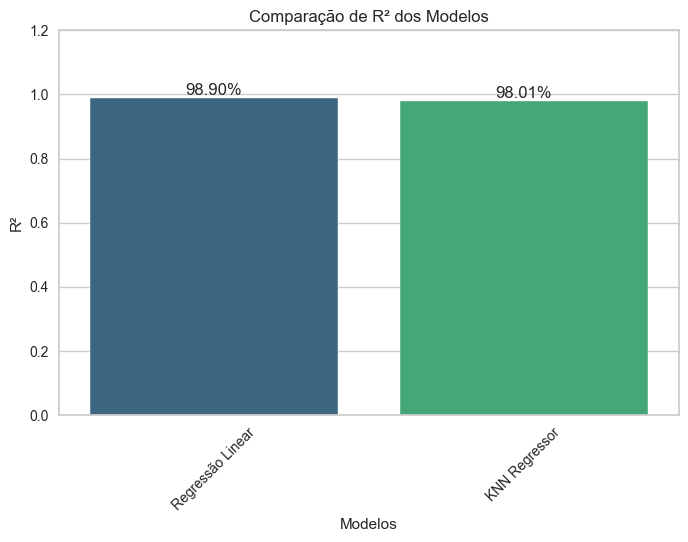

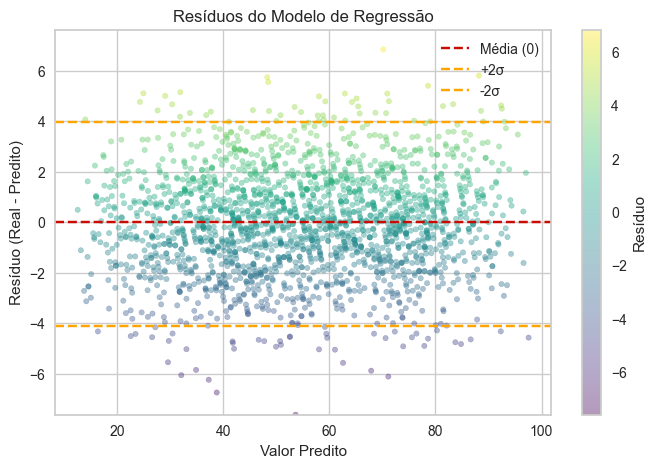

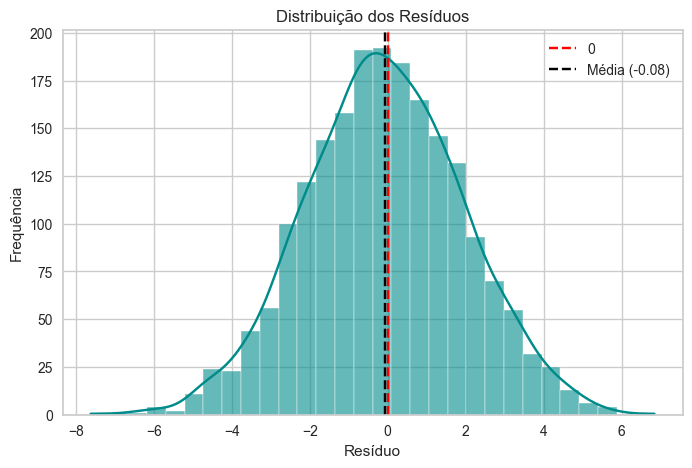

In [27]:

if problema == "classificacao":
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=df_resultados.index, y='Acurácia', data=df_resultados, palette="viridis")
    plt.ylim(0, 1.2)
    plt.title("Comparação de Acurácia dos Modelos")
    plt.ylabel("Acurácia")
    plt.xlabel("Modelos")
    plt.xticks(rotation=45)
    # Para cada barra, adicionar o valor percentual
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{v.get_height()*100:.2f}%' for v in container])
    plt.show()

    matriz = confusion_matrix(y_teste, y_pred, labels=best_models[melhor].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes_por_extenso)
    disp.plot(cmap=plt.cm.viridis)
    plt.grid(False)
    plt.title('Matriz de Confusão')
    plt.show()

    visualizer = yb.ClassificationReport(
                                        best_models[melhor],
                                        classes=classes_por_extenso,
                                        cmap= "Greens",
                                        support=True)
    visualizer.fit(x_treino, y_treino)
    visualizer.score(x_teste, y_teste)
    visualizer.show()

else:
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=df_resultados.index, y='R²', data=df_resultados, palette="viridis")
    plt.ylim(0, 1.2)
    plt.title("Comparação de R² dos Modelos")
    plt.ylabel("R²")
    plt.xlabel("Modelos")
    plt.xticks(rotation=45)
    # Para cada barra, adicionar o valor percentual
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{v.get_height()*100:.2f}%' for v in container])
    plt.show()

    # Cálculo dos resíduos
    residuos = y_teste - y_pred
    media_resid = np.mean(residuos)
    std_resid = np.std(residuos)

    # Dispersão resíduos vs preditos
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuos, alpha=0.4, s=15, c=residuos, cmap="viridis")
    plt.axhline(y=0, color="r", linestyle="--", label="Média (0)")
    plt.axhline(media_resid + 2*std_resid, color="orange", linestyle="--", label="+2σ")
    plt.axhline(media_resid - 2*std_resid, color="orange", linestyle="--", label="-2σ")
    plt.xlabel("Valor Predito")
    plt.ylabel("Resíduo (Real - Predito)")
    plt.title("Resíduos do Modelo de Regressão")
    plt.legend()
    plt.colorbar(label="Resíduo")
    limite = max(abs(residuos.min()), abs(residuos.max()))
    plt.ylim(-limite, limite)
    plt.show()

    # Histograma da distribuição dos resíduos
    plt.figure(figsize=(8,5))
    sns.histplot(residuos, bins=30, kde=True, color="darkcyan", alpha=0.6)
    plt.axvline(0, color="red", linestyle="--", label="0")
    plt.axvline(media_resid, color="black", linestyle="--", label=f"Média ({media_resid:.2f})")
    plt.title("Distribuição dos Resíduos")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()
